# Boxing competititon (binary classification)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from catboost import CatBoostClassifier, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split as split
warnings.filterwarnings(action='once')
from sklearn import preprocessing
import lightgbm

/home/egor/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We have to solve a binary classification problen (if a fighter wins or not)

In [2]:
df = pd.read_excel('data.xlsx', header=0)

In [3]:
df.head()

,Number,Date,fight_id,fighter_id,feature0,feature1,feature2,feature3,Wins,Losses,...,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,Winner Result
0,1,2007-06-14,59289,19260,2557,1,1,25,8,1,...,2.0000,20.3333,0.0000,20.6667,0.3333,108.6667,36.0000,2.0000,2.6667,1
1,2,2007-06-14,59289,19398,3520,0,0,38,8,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,2007-06-14,59291,7742,3360,1,2,28,12,4,...,7.5000,21.1667,0.8333,24.6667,0.3333,174.3333,70.1667,0.1667,0.6667,0
3,4,2007-06-14,59291,11285,11029,3,2,26,20,6,...,1.0000,2.6000,0.2000,3.2000,0.0000,17.4000,29.4000,6.4000,9.6000,1
4,5,2007-06-14,59292,14615,14148,1,1,25,21,7,...,3.2667,13.3333,0.8000,14.7333,0.0000,103.0000,36.7500,5.8667,10.8667,0


Let's split date on year and month

In [4]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df['Month'], df['Year'], df['Day'], df['day_of_week'] = df['Date'].dt.month, df['Date'].dt.year, df['Date'].dt.day, df['Date'].dt.dayofweek
data = df.apply(lambda x: x.fillna('NaN') if x.dtype.kind == 'object' else x.fillna(0))
result = data['Winner Result']
data.drop(['Number', 'Date', 'Winner Result', 'fight_id'], axis=1, inplace=True)
le = preprocessing.LabelEncoder()
data['Stance'] = le.fit_transform(data['Stance'].astype(str))

Let's use one-hot encoding for features which seem to be categorical (we will check how to treat these features later)

one_hot1 = pd.get_dummies(data['Stance'])
one_hot2 = pd.get_dummies(data['Weight Class'])
data_enc = data.drop(['Weight Class', 'Stance'], axis=1)
data_enc = data_enc.join([one_hot1, one_hot2])

## Feature selection

Let's use LGBMClassifier model for further feature selection

In [29]:
%%time
features = [
            'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds', 'Opening odds',
            'Month', 'Year', 'Day', 'day_of_week',
            'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature6.1',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20',
            'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
            'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
            'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
            'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
            'feature41', 'feature42', 'feature43', 'feature44', 'feature45',
            'feature46', 'feature47', 'feature48'
           ]

X_train, X_test, y_train, y_test = split(data[features], result, test_size=0.2, shuffle=True, random_state=42)

CPU times: user 9.07 ms, sys: 0 ns, total: 9.07 ms
Wall time: 8.18 ms


In [46]:
lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)

lgb.fit(X_train, y_train,
        sample_weight=None,
        init_score=None,
        eval_set=(X_test, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=features,
        categorical_feature=[4, 5],
        callbacks=None)

print(accuracy_score(y_train, lgb.predict(X_train)), accuracy_score(y_test, lgb.predict(X_test)))


/home/egor/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/egor/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [4, 5]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


ValueError: Length of feature_name(62) and num_feature(1661) don't match

In [10]:
%%time
features_to_add = data.drop([ 'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds'], axis=1).columns

data_test = data[['fighter_id', 'Wins', 'Losses', 'Draws',
'Weight Class', 'Stance', 'Odds']]
features_results = []
lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000)
for feature in features_to_add:
    features_results.append(np.mean(cross_val_score(lgb, data_test, result, cv=5, n_jobs=2)))
    data_test[feature] = data[feature]

KeyboardInterrupt: 

Text(0.5,1,'Comparing different features in model')

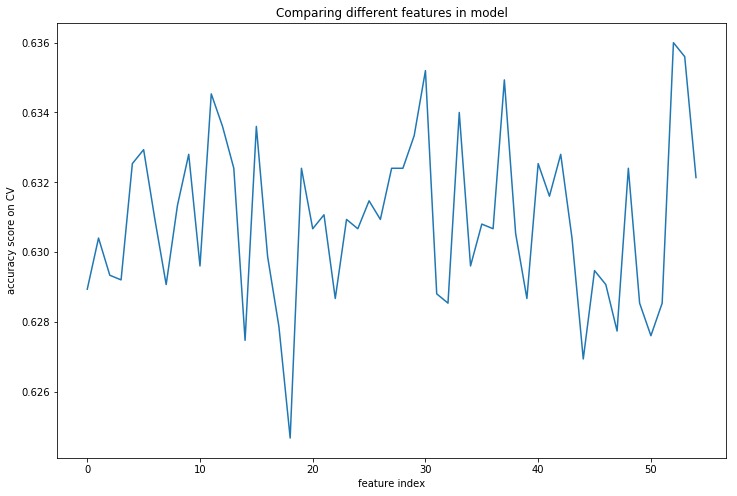

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(len(features_results)), features_results)
ax.set_xlabel('feature index')
ax.set_ylabel('accuracy score on CV')
ax.set_title('Comparing different features in model')

that there's some difference with features. Let's try to select the best features

For tuning different features we can use models like random grid CV. Let's split our data on 2 parts to check the difference further

Let's use greedy algorithm for tuning features

1) Estimate features by its impact on model with static features

2) Sort features by it's impact

3) Add features to model by sorted list order

4) Analyse results on graph

5) Compare results with full-featured model

In [65]:
train_features

Index(['feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'Opening odds', 'feature6.1', 'feature7', 'feature8',
       'feature9', 'feature10', 'feature11', 'feature12', 'feature13',
       'feature14', 'feature15', 'feature16', 'feature17', 'feature18',
       'feature19', 'feature20', 'feature21', 'feature22', 'feature23',
       'feature24', 'feature25', 'feature26', 'feature27', 'feature28',
       'feature29', 'feature30', 'feature31', 'feature32', 'feature33',
       'feature34', 'feature35', 'feature36', 'feature37', 'feature38',
       'feature39', 'feature40', 'feature41', 'feature42', 'feature43',
       'feature44', 'feature45', 'feature46', 'feature47', 'feature48',
       'Month', 'Year', 'Day', 'day_of_week'],
      dtype='object')

In [66]:
feature_diffs = []
train_features = list(features_to_add)
for i in range(1, len(features_results)):
    feature_diffs.append(features_results[i] - features_results[i-1])
    print(features_results[i] - features_results[i-1])
    print('{} - {}'.format(train_features[i], train_features[i-1]))
    print('{} - {}'.format(features_results[i], features_results[i-1]))
    print()
#We need to delete train_feature[0] ('feature1')
train_features.pop(0)
diff_feat_dict = dict(zip(feature_diffs, train_features))

0.0014666666666667272
feature1 - feature0
0.6304000000000001 - 0.6289333333333333

-0.0010666666666667712
feature2 - feature1
0.6293333333333333 - 0.6304000000000001

-0.00013333333333331865
feature3 - feature2
0.6292 - 0.6293333333333333

0.0033333333333332993
feature4 - feature3
0.6325333333333333 - 0.6292

0.00040000000000006697
feature5 - feature4
0.6329333333333333 - 0.6325333333333333

-0.0020000000000000018
feature6 - feature5
0.6309333333333333 - 0.6329333333333333

-0.0018666666666666831
Opening odds - feature6
0.6290666666666667 - 0.6309333333333333

0.002266666666666639
feature6.1 - Opening odds
0.6313333333333333 - 0.6290666666666667

0.0014666666666666162
feature7 - feature6.1
0.6327999999999999 - 0.6313333333333333

-0.0031999999999997586
feature8 - feature7
0.6296000000000002 - 0.6327999999999999

0.004933333333333123
feature9 - feature8
0.6345333333333333 - 0.6296000000000002

-0.0009333333333333416
feature10 - feature9
0.6335999999999999 - 0.6345333333333333

-0.001199

In [67]:
print(len(train_features), len(feature_diffs))

54 54


In [68]:
from collections import OrderedDict
diff_feat_dict = OrderedDict(sorted(diff_feat_dict.items(), key=lambda t: t[0], reverse=True))

In [69]:
diff_feat_dict

OrderedDict([(0.007733333333333481, 'feature17'),
             (0.0074666666666668435, 'Year'),
             (0.006133333333333435, 'feature13'),
             (0.005466666666666842, 'feature31'),
             (0.004933333333333123, 'feature9'),
             (0.004666666666666708, 'feature46'),
             (0.004266666666666641, 'feature35'),
             (0.003866666666666685, 'feature38'),
             (0.0033333333333332993, 'feature4'),
             (0.0025333333333332764, 'feature43'),
             (0.00226666666666675, 'feature21'),
             (0.002266666666666639, 'feature6.1'),
             (0.0018666666666666831, 'feature28'),
             (0.0014666666666667272, 'feature25'),
             (0.0014666666666666162, 'feature7'),
             (0.0012000000000000899, 'feature33'),
             (0.0011999999999999789, 'feature40'),
             (0.0009333333333332305, 'Month'),
             (0.0008000000000000229, 'feature23'),
             (0.00040000000000006697, 'feature19'),


In [70]:
%%time
X_train_t = X_train.drop(train_features, axis=1)
features_results3 = []
dict_to_work = diff_feat_dict.copy()
feature_names = []
data_with_static_features = X_train.drop(train_features, axis=1)
to_break = False
for e in range(10):
    if e == 0:
        value_on_step = list(dict_to_work.keys())[0]
        X_train_t[dict_to_work[value_on_step]] = X_train[dict_to_work[value_on_step]]
        feature_names.append(dict_to_work[value_on_step])
        print(dict_to_work[value_on_step], 'popped')
        dict_to_work.pop(value_on_step)
        features_results3.append(np.mean(cross_val_score(lgb, X_train_t, y_train, cv=5, n_jobs=2)))
    if to_break:
        X_train_t.drop(feature_names.pop(), axis=1, inplace=True)
        features_results3.pop()
        break
    else:
        data = X_train_t.copy()
        acc_on_step = 0
        value_on_step = 0
        i = 0
        while acc_on_step <= features_results3[e]:
            if i >= len(dict_to_work):
                to_break = True
                break
            value_on_step = list(dict_to_work.keys())[i]
            data[dict_to_work[value_on_step]] = X_train[diff_feat_dict[value_on_step]]
            acc_on_step = np.mean(cross_val_score(lgb, data, y_train, cv=5, n_jobs=2))
            print(i, acc_on_step, dict_to_work[value_on_step], len(dict_to_work))
            i += 1
        features_results3.append(acc_on_step)
        X_train_t[dict_to_work[value_on_step]] = X_train[dict_to_work[value_on_step]]
        feature_names.append(dict_to_work[value_on_step])
        print(dict_to_work[value_on_step], 'popped')
        dict_to_work.pop(value_on_step)
    

feature17 popped
0 0.6288307291648583 Year 48
1 0.6354983716423878 feature13 48
feature13 popped
0 0.6354983716423878 Year 47
1 0.6324983695590529 feature31 47
2 0.6306654532398981 feature9 47
3 0.634000731713471 feature46 47
4 0.6326626754601913 feature35 47
5 0.634496983678461 feature38 47
6 0.6281694811362136 feature4 47
7 0.6323311508086695 feature43 47
8 0.6294997591433512 feature21 47
9 0.6286648979154383 feature6.1 47
10 0.6298329546293666 feature28 47
11 0.6298329546293666 feature25 47
12 0.6369989295131455 feature7 47
feature7 popped
0 0.6328319811333203 Year 46
1 0.6241655915501794 feature31 46
2 0.6329982307858085 feature9 46
3 0.6289967017338206 feature46 46
4 0.6276643416650521 feature35 46
5 0.6338310104150534 feature38 46
6 0.6353323999993518 feature4 46
7 0.6320008718756055 feature43 46
8 0.6349978174753362 feature21 46
9 0.6311669809029959 feature6.1 46
10 0.6369989295131455 feature28 46
11 0.6369989295131455 feature25 46
12 0.6248325336800002 feature33 46
13 0.6313296

Text(0.5,1,'Comparing different features in the model')

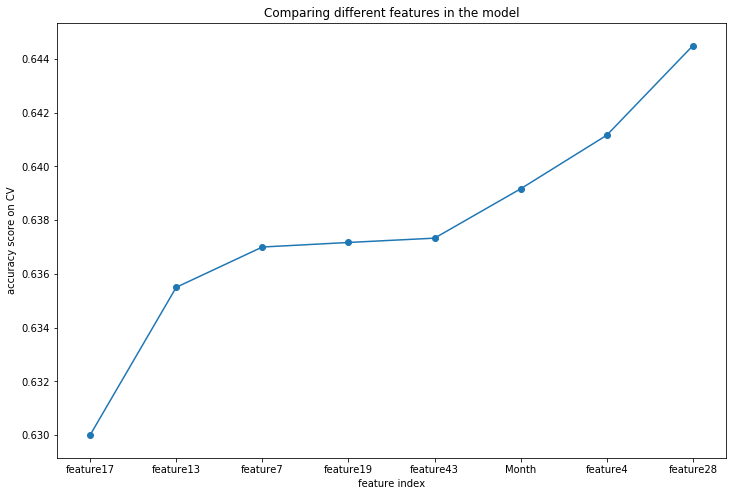

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(feature_names, features_results3)
ax.scatter(feature_names, features_results3)
ax.set_xlabel('feature index')
ax.set_ylabel('accuracy score on CV')
ax.set_title('Comparing different features in the model')

In [72]:
X_test_t = X_test[X_train_t.columns]

In [ ]:
med = []
lgb = LGBMClassifier(boosting_type='gbdt',
                     num_leaves=11,
                     max_depth=4,
                     learning_rate=0.1,
                     n_estimators=1000,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)
for i in range(5):
    lgb.fit(X_train_t, y_train,
        eval_set=(X_test_t, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=list(X_test_t.columns),
        categorical_feature=[0, 4, 5, 13])
    med.append(accuracy_score(y_test, lgb.predict(X_test_t)))

In [ ]:
med2 = []
for i in range(5):
    lgb.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        eval_names=None,
        eval_sample_weight=None,
        eval_class_weight=None,
        eval_init_score=None,
        eval_metric='logloss',
        early_stopping_rounds=None,
        verbose=True,
        feature_name=list(X_test.columns),
        categorical_feature=[0, 4, 5])
    med2.append(accuracy_score(np.array(y_test), lgb.predict(X_test)))

In [99]:
print(np.mean(med))
print(np.mean(med2))

0.65
0.6486666666666666


As we can see, lgb model fitted with selected features works ~2-3 times faster and has better accuracy

# Categorical features vs non-categorical features

Let's find out what features better to treat as categorical using catboostclassifier model on our selected features

## CatBosstClassifier

We don't need to use GridSearchCV for CatBoost because there's a built-in option (use_best_model=True) to find the best parameters for a model

In [101]:
normal_features = list(X_test_t.columns)
for i in range(len(normal_features)):
    print(i, normal_features[i])

0 fighter_id
1 Wins
2 Losses
3 Draws
4 Weight Class
5 Stance
6 Odds
7 feature0
8 feature17
9 feature13
10 feature7
11 feature19
12 feature43
13 Month
14 feature4
15 feature28


In [102]:
data = df.dropna()
result = data['Winner Result']
data.drop(['Number', 'fight_id', 'Date', 'Winner Result'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = split(data[normal_features], result, train_size=0.75, shuffle=True, random_state=42)

C:\Users\Aqice\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [103]:
# 0 ('Stance') - is constant-categorical feature
feature_comb = [[5], [5, 0], [5, 4], [5, 0, 4]]
acc_score_cat = {}
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
for cat_index in feature_comb:
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=list(cat_index), silent=True, use_best_model=True)
    acc_score_cat[str(cat_index)] = [accuracy_score(y_test, cat.predict(X_test)), accuracy_score(y_train, cat.predict(X_train))]

Learning rate set to 0.091798
Learning rate set to 0.091798
Learning rate set to 0.091798
Learning rate set to 0.091798


[5]:
test accuracy: 0.6575255102040817
train accuracy: 0.7198468410976387

[5, 0]:
test accuracy: 0.71875
train accuracy: 0.8596043395022336

[5, 4]:
test accuracy: 0.6594387755102041
train accuracy: 0.706019995745586

[5, 0, 4]:
test accuracy: 0.7021683673469388
train accuracy: 0.8136566687938737



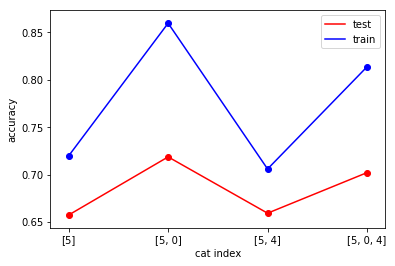

In [111]:
for values, key in zip(acc_score_cat.values(), acc_score_cat.keys()):
    print('{}:'.format(key))
    print('test accuracy: {}'.format(values[0]))
    print('train accuracy: {}'.format(values[1]))
    print()
plt.xlabel('cat index')
plt.ylabel('accuracy')
plt.plot(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 0], color='red', label='test')
plt.plot(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 1], color='blue', label='train')
plt.scatter(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 0], color='red')
plt.scatter(list(acc_score_cat.keys()), np.array(list(acc_score_cat.values()))[:, 1], color='blue')
plt.legend()
plt.show()

In [109]:
%%time
cat.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=[0, 5], silent=True, use_best_model=True)

Learning rate set to 0.091798
Wall time: 33.8 s


In [112]:
print(cat.get_params())
cat_train_acc = accuracy_score(y_train, cat.predict(X_train))
cat_test_acc = accuracy_score(y_test, cat.predict(X_test))
print('cat (train): {}'.format(cat_train_acc))
print('cat (test): {}'.format(cat_test_acc))

{'allow_writing_files': False, 'eval_metric': 'Accuracy', 'use_best_model': True, 'loss_function': 'Logloss'}
cat (train): 0.8391831525207403
cat (test): 0.7295918367346939


## Logistic regression

For logistic regression model we need to use one-hot encoding for categorical features

In [113]:
one_hot1 = pd.get_dummies(data['Stance'])
one_hot2 = pd.get_dummies(data['fighter_id'])
data_enc = data[normal_features].drop(['Weight Class', 'Stance'], axis=1)
data_enc = data_enc.join([one_hot1, one_hot2])
X_train_enc, X_test_enc, y_train, y_test = split(data_enc, result, train_size=0.75, shuffle=True, random_state=42)

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's try out logistic regression with parameters' tuning with GridSearchCV

In [114]:
%%time
lgGridParams = {
    'penalty' : ['l1', 'l2'],
    'C' : list(np.linspace(0.1, 2, 20)),
    }
lg = LogisticRegression()
lg_clf = GridSearchCV(lg, lgGridParams, cv=3)
lg_best_model = lg_clf.fit(X_train_enc, y_train)

Wall time: 22.8 s


In [115]:
print(lg_best_model.best_estimator_.get_params())
lg_train_acc = accuracy_score(y_train, lg_best_model.predict(X_train_enc))
lg_test_acc = accuracy_score(y_test, lg_best_model.predict(X_test_enc))
print('lg (train): {}'.format(lg_train_acc))
print('lg (test): {}'.format(lg_test_acc))

{'C': 0.8999999999999999, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
lg (train): 0.6604977664326739
lg (test): 0.6441326530612245


## Lightgbm

There are many parameters to tune in Lightgbm. Let's use RandomizedSearchCV to make the tuning faster 

In [121]:
lgbGridParams = {
    'learning_rate': np.arange(0.001, 0.1, 0.005),
    'n_estimators': list(range(100,1000, 20)),
    'num_leaves': list(range(2,50, 1)),
    'max_depth': list(range(2,10)),
    'reg_alpha': np.arange(0, 3, 0.2),
    'reg_lambda': np.arange(0, 1, 0.1)
    }
lgb = LGBMClassifier(boosting_type='gbdt',
                     learning_rate=0.1,
                     subsample_for_bin=20000,
                     objective=None,
                     class_weight=None,
                     min_split_gain=0.0,
                     min_child_weight=0.001,
                     min_child_samples=20,
                     subsample=.75,
                     subsample_freq=1,
                     colsample_bytree=1.0,
                     reg_alpha=0.0,
                     reg_lambda=0.0,
                     random_state=0,
                     n_jobs=-1,
                     silent=True,
                     feature_fraction=.75,
                     begging_fraction=.75,
                     begging_freq=1,
                     early_stopping_round=100)

lgb_clf_random = RandomizedSearchCV(lgb, lgbGridParams, n_iter=2000)
# let's encode Stance and fighter_id for RandomizedSearchCV fitting
stance = {'open stance': 1, 'orthodox': 2, 'southpaw': 3, 'switch': 4} 
X_train_num_cat, X_test_num_cat = X_train.copy(), X_test.copy()
X_train_num_cat['Stance'] = [stance[item] for item in X_train_num_cat['Stance']]
X_train_num_cat['fighter_id'] = pd.to_numeric(X_train_num_cat['fighter_id'])
X_test_num_cat['Stance'] = [stance[item] for item in X_test_num_cat['Stance']]
X_test_num_cat['fighter_id'] = pd.to_numeric(X_test_num_cat['fighter_id'])

In [ ]:
lgb_best_model = lgb_clf_random.fit(X_train_num_cat, y_train,
                    eval_set=(X_test_num_cat, y_test),
                    eval_names=None,
                    eval_sample_weight=None,
                    eval_class_weight=None,
                    eval_init_score=None,
                    eval_metric='logloss',
                    early_stopping_rounds=None,
                    verbose=True,
                    feature_name=list(X_test_num_cat.columns))

In [123]:
print(lgb_best_model.best_estimator_.get_params())
lgb_train_acc = accuracy_score(y_train, lgb_best_model.predict(X_train_num_cat))
lgb_test_acc = accuracy_score(y_test, lgb_best_model.predict(X_test_num_cat))
print('lgb (train): {}'.format(lgb_train_acc))
print('lgb (test): {}'.format(lgb_test_acc))

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 540, 'n_jobs': -1, 'num_leaves': 18, 'objective': None, 'random_state': 0, 'reg_alpha': 2.8000000000000003, 'reg_lambda': 0.5, 'silent': True, 'subsample': 0.75, 'subsample_for_bin': 20000, 'subsample_freq': 1, 'feature_fraction': 0.75, 'begging_fraction': 0.75, 'begging_freq': 1, 'early_stopping_round': 100}
lgb (train): 0.7058072750478621
lgb (test): 0.6441326530612245


C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Let's look at final results of each classifier

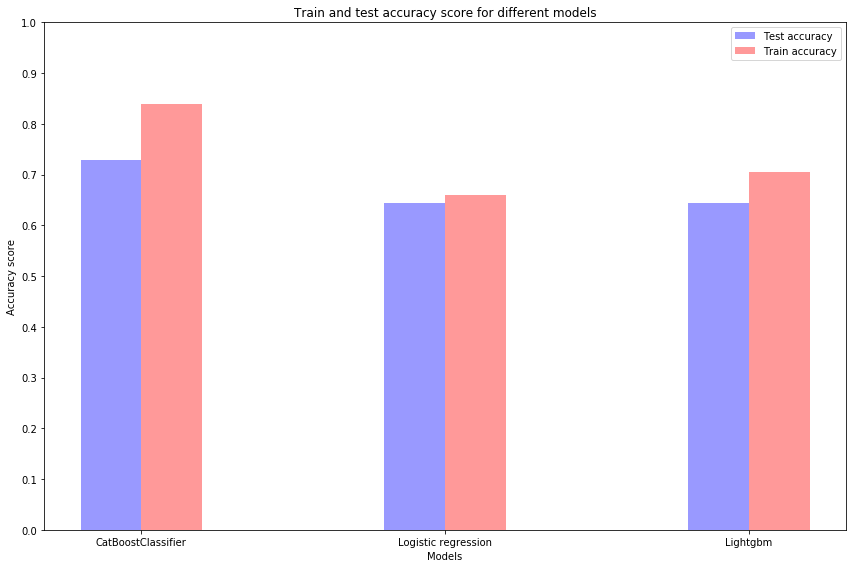

In [124]:
test_acc = (cat_test_acc, lg_test_acc, lgb_test_acc)
train_acc = (cat_train_acc, lg_train_acc, lgb_train_acc)
fig, ax = plt.subplots(figsize=(12, 8))
index = np.arange(3)
bar_width = 0.2
opacity = 0.4
error_config = {'ecolor': '0.4'}

rects1 = ax.bar(index, test_acc, bar_width, alpha=opacity, color='b', error_kw=error_config, label='Test accuracy')
rects2 = ax.bar(index + bar_width, train_acc, bar_width, alpha=opacity, color='r', error_kw=error_config, label='Train accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy score')
ax.set_title('Train and test accuracy score for different models')
ax.set_xticks(index + bar_width / 2)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(('CatBoostClassifier', 'Logistic regression', 'Lightgbm'))
ax.legend()

fig.tight_layout()
plt.show()

In [125]:
print('lg and lgb answers simularity: {}'.format(
    accuracy_score(lg_best_model.predict(X_test_enc), lgb_best_model.predict(X_test_num_cat))
    ))
print('lg and cat answers simularity: {}'.format(
    accuracy_score(lg_best_model.predict(X_test_enc), cat.predict(X_test))
    ))
print('lgb and cat answers simularity: {}'.format(
    accuracy_score(lgb_best_model.predict(X_test_num_cat), cat.predict(X_test))
    ))

lg and lgb answers simularity: 0.8788265306122449
lg and cat answers simularity: 0.764030612244898
lgb and cat answers simularity: 0.7971938775510204


C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Ensembling

In [131]:
def alg_ensemble(pred_list, y):
    #pred_list.shape[1] should be 3
    result = {}
    A, B, C = np.arange(0.8, 2, 0.1), np.arange(0.2, 1, 0.05), np.arange(0.2, 1, 0.05)
    for a in A:
        for b in B:
            for c in C:
                ans = np.zeros(len(y))
                for i in range(len(ans)):
                    ans[i] = (a * pred_list[i, 0] + b * pred_list[i, 1] + c * pred_list[i, 2]) / 3
                    ans[i] = 1 if ans[i] >= 0.5 else 0
                result[str([a,b,c])] = accuracy_score(y, ans)
        print(a)
    return result
        

In [127]:
preds_test = []
preds_train = []
preds_test.append(cat.predict(X_test))
preds_train.append(cat.predict(X_train))
preds_test.append(lg_best_model.predict(X_test_enc))
preds_train.append(lg_best_model.predict(X_train_enc))
preds_test.append(lgb_best_model.predict(X_test_num_cat))
preds_train.append(lgb_best_model.predict(X_train_num_cat))
preds_test = np.array(preds_test)
preds_train = np.array(preds_train)

C:\Users\Aqice\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [132]:
preds_test_ens = alg_ensemble(preds_test.T, y_test)

0.8
0.9
1.0
1.1
1.2
1.2999999999999998
1.4
1.5
1.5999999999999999
1.6999999999999997
1.7999999999999998
1.8999999999999997


In [133]:
print(max(preds_test_ens.values()))

0.7295918367346939


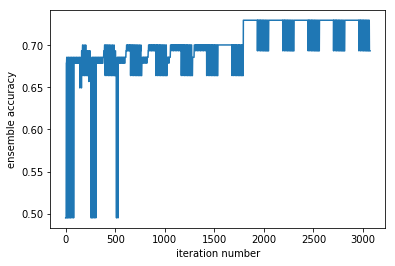

In [134]:
plt.plot(list(range(len(preds_test_ens.values()))), preds_test_ens.values())
plt.xlabel('iteration number')
plt.ylabel('ensemble accuracy')
plt.show()

We can see that max value of the best model = best blending value

So it's the best approch so far. Let's try to change conception and impore catboost's model

## Categorical features selection (wider approach)

In [6]:
features = [
            'fighter_id', 'Wins', 'Losses', 'Draws',
            'Weight Class', 'Stance', 'Odds', 'Opening odds',
            'Month', 'Year', 'Day', 'day_of_week',
            'feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature6.1',
            'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
            'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
            'feature17', 'feature18', 'feature19', 'feature20',
            'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
            'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
            'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
            'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
            'feature41', 'feature42', 'feature43', 'feature44', 'feature45',
            'feature46', 'feature47', 'feature48'
           ]

X_train, X_test, y_train, y_test = split(data[features], result, test_size=0.25, shuffle=True, random_state=42)

In [23]:
for i in enumerate(features):
    print(i[0], i[1])

0 fighter_id 32233.0
1 Wins 19.0
2 Losses 4.0
3 Draws 0.0
4 Weight Class 155.0
5 Stance 3.0
6 Odds -300.0
7 Opening odds -275.0
8 Month 1.0
9 Year 2014.0
10 Day 23.0
11 day_of_week 3.0
12 feature0 16644.0
13 feature1 7.0
14 feature2 1.0
15 feature3 30.0
16 feature4 446.0
17 feature5 65.748
18 feature6 65.3846
19 feature6.1 4.0
20 feature7 6.0
21 feature8 9.0
22 feature9 175.26
23 feature10 1.0
24 feature11 2.7
25 feature12 724.0
26 feature13 0.8
27 feature14 1.04073159928618
28 feature15 63.1249900100223
29 feature16 0.9716738972019452
30 feature17 1.8723
31 feature18 11459.304996
32 feature19 70.0
33 feature20 84.0316
34 feature21 288.2222
35 feature22 13.6383
36 feature23 30.7447
37 feature24 0.8723
38 feature25 1.8723
39 feature26 40.9149
40 feature27 0.4894
41 feature28 0.2766
42 feature29 2.9149
43 feature30 3.1064
44 feature31 0.4468
45 feature32 22.4894
46 feature33 6.4468
47 feature34 3.383
48 feature35 19.3404
49 feature36 4.7872
50 feature37 2.766
51 feature38 1.617
52 featur

Let's filter all features which can be categorical theoretically 

Stance feature should always be categorical

In [48]:
import itertools


cat_possible_combination = []
cat_feat = [0,1,2,3,4,5,8,9,10,11, 23, 21, 20, 19]
for L in range(0, len(cat_feat)+1):
    for subset in itertools.combinations(cat_feat, L):
        cat_possible_combination.append(list(subset))
for i in cat_possible_combination:
    if not 0 in i:
        i.append(0)
    if not 5 in i:
        i.append(5)
cat_possible_combination_new = []
for i in cat_possible_combination:
    if i not in cat_possible_combination_new:
        cat_possible_combination_new.append(i)
cat_possible_combination = cat_possible_combination_new
del cat_possible_combination_new

## Directed cat features appending

In [105]:
%%time

cur_cat_features = [5]
cat_feat = [0,1,2,3,4,8,9,10,11, 23, 21, 20, 19]
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
cat_feature_dict = {}
for new_feature in cat_feat:
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=cur_cat_features,
            use_best_model=True, silent=True)
    
    cat_feature_dict[str(cur_cat_features)] = [accuracy_score(cat.predict(X_test), y_test), 
                                                                   accuracy_score(cat.predict(X_train), y_train)]
    print("Current feature list: {}".format(str(cur_cat_features)))
    cur_cat_features.append(new_feature)

Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Learning rate set to 0.093544
29 out of 30
Wall time: 13min 4s


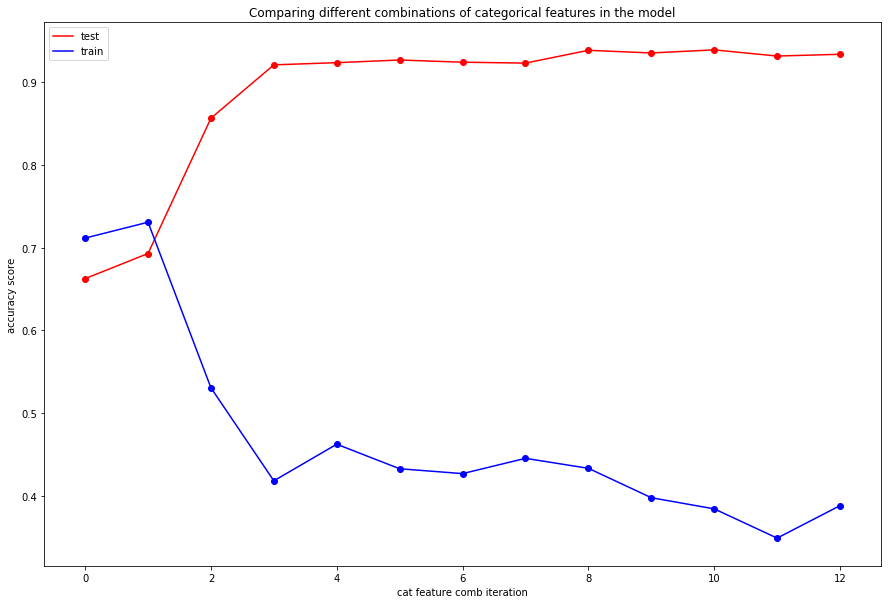

In [106]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red', label='test')
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue', label='train')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue')
ax.set_xlabel('cat feature comb iteration')
ax.set_ylabel('accuracy score')
ax.set_title('Comparing different combinations of categorical features in the model')
ax.legend()

We can see a big overfitting if we treat many feature as categorical. Let's try to find the best combinations

## Random cat features appending

In [109]:
%%time
from numpy import random as rand

num_iters = 100
cat = CatBoostClassifier(eval_metric='Accuracy',
                         allow_writing_files=False,
                         use_best_model=True)
cat_feature_dict = {}
for i in range(num_iters):
    random_num = rand.randint(len(cat_possible_combination))
    cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=list(cat_possible_combination[random_num]),
            use_best_model=True, silent=True)
    cat_feature_dict[str(cat_possible_combination[random_num])] = [accuracy_score(cat.predict(X_test), y_test), 
                                                                   accuracy_score(cat.predict(X_train), y_train)]
    print("{} out of {}".format(i, num_iters))

Learning rate set to 0.093544
0 out of 100
Learning rate set to 0.093544
1 out of 100
Learning rate set to 0.093544
2 out of 100
Learning rate set to 0.093544
3 out of 100
Learning rate set to 0.093544
4 out of 100
Learning rate set to 0.093544
5 out of 100
Learning rate set to 0.093544
6 out of 100
Learning rate set to 0.093544
7 out of 100
Learning rate set to 0.093544
8 out of 100
Learning rate set to 0.093544
9 out of 100
Learning rate set to 0.093544
10 out of 100
Learning rate set to 0.093544
11 out of 100
Learning rate set to 0.093544
12 out of 100
Learning rate set to 0.093544
13 out of 100
Learning rate set to 0.093544
14 out of 100
Learning rate set to 0.093544
15 out of 100
Learning rate set to 0.093544
16 out of 100
Learning rate set to 0.093544
17 out of 100
Learning rate set to 0.093544
18 out of 100
Learning rate set to 0.093544
19 out of 100
Learning rate set to 0.093544
20 out of 100
Learning rate set to 0.093544
21 out of 100
Learning rate set to 0.093544
22 out of 10

In [110]:
import operator
sorted(cat_feature_dict.items(), key=operator.itemgetter(1), reverse=True)

[('[0, 1, 2, 4, 8, 9, 10, 23, 21, 19, 5]',
  [0.9365333333333333, 0.42133333333333334]),
 ('[1, 2, 3, 4, 9, 10, 11, 20, 19, 0, 5]',
  [0.9338666666666666, 0.37493333333333334]),
 ('[1, 2, 4, 10, 23, 19, 0, 5]', [0.9322666666666667, 0.44106666666666666]),
 ('[1, 2, 3, 8, 10, 11, 23, 21, 0, 5]', [0.9296, 0.4149333333333333]),
 ('[1, 2, 3, 5, 10, 11, 20, 0]', [0.928, 0.44693333333333335]),
 ('[1, 2, 3, 4, 5, 8, 9, 0]', [0.928, 0.4298666666666667]),
 ('[1, 2, 5, 20, 19, 0]', [0.9274666666666667, 0.4232888888888889]),
 ('[0, 1, 2, 4, 5, 8, 9, 11, 21, 20, 19]',
  [0.9269333333333334, 0.41955555555555557]),
 ('[0, 1, 2, 3, 8, 10, 23, 20, 5]', [0.9253333333333333, 0.4384]),
 ('[1, 2, 3, 4, 5, 23, 21, 19, 0]', [0.9248, 0.4369777777777778]),
 ('[1, 2, 5, 8, 9, 10, 23, 21, 20, 0]', [0.9248, 0.4033777777777778]),
 ('[1, 2, 5, 9, 20, 0]', [0.9242666666666667, 0.43822222222222224]),
 ('[0, 1, 2, 4, 8, 11, 20, 19, 5]', [0.9226666666666666, 0.44693333333333335]),
 ('[0, 1, 2, 5, 10, 20]', [0.922666666

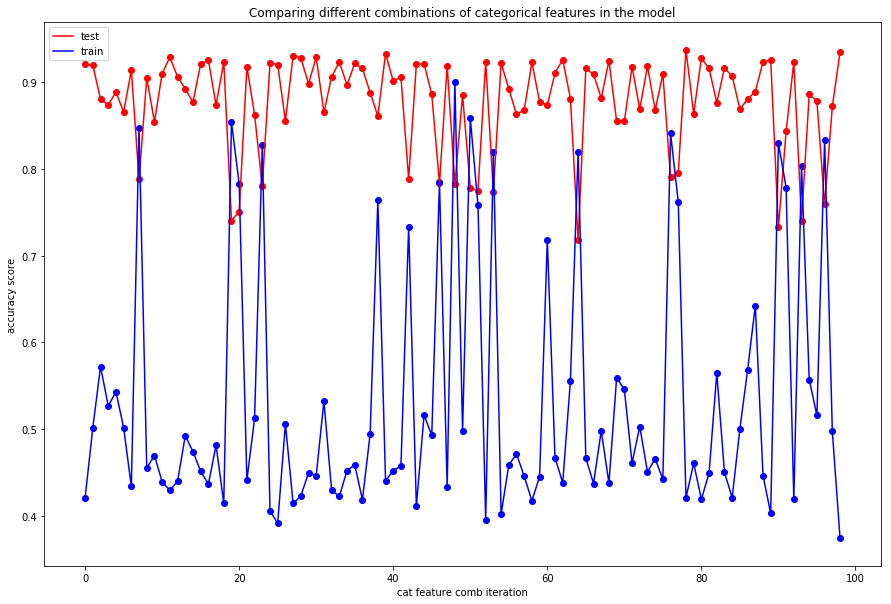

In [111]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red', label='test')
ax.plot(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue', label='train')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 0], color='red')
ax.scatter(list(range(len(cat_feature_dict))), (np.array(list(cat_feature_dict.values())))[:, 1], color='blue')
ax.set_xlabel('cat feature comb iteration')
ax.set_ylabel('accuracy score')
ax.set_title('Comparing different combinations of categorical features in the model')
ax.legend()

We can see a strong overfitting. Let's see only valid values (train acc > test acc)

In [57]:
for key, value in cat_feature_dict.items():
    if value[1] >= value[0]:
        print(key, value)

('[3, 5, 9, 10, 11, 23, 21, 0]', [0.7781333333333333, 0.8577777777777778])
('[3, 5, 8, 9, 21, 0]', [0.7402666666666666, 0.8030222222222222])
('[0, 5, 9, 11, 23, 20, 19]', [0.7589333333333333, 0.8330666666666666])
('[0, 3, 8, 9, 10, 11, 21, 5]', [0.7728, 0.8192])
('[0, 3, 4, 8, 11, 20, 19, 5]', [0.7322666666666666, 0.8291555555555555])
('[0, 3, 5, 8, 9, 10, 21, 20]', [0.7877333333333333, 0.8464])
('[4, 5, 9, 23, 21, 20, 0]', [0.7824, 0.8999111111111111])
('[4, 5, 11, 23, 21, 0]', [0.7504, 0.7822222222222223])
('[0, 8, 9, 10, 11, 23, 21, 5]', [0.7898666666666667, 0.8405333333333334])
('[3, 5, 8, 9, 10, 11, 21, 20, 0]', [0.7829333333333334, 0.7843555555555556])
('[8, 9, 10, 0, 5]', [0.7402666666666666, 0.8531555555555556])
('[4, 10, 19, 0, 5]', [0.7173333333333334, 0.8195555555555556])
('[4, 8, 9, 23, 21, 20, 0, 5]', [0.7797333333333333, 0.8272])


In [117]:
cat.fit(X_train, y_train, eval_set=(X_test, y_test), 
            cat_features=[0, 3, 5, 10, 11, 21, 19],
            use_best_model=True, silent=True)

Learning rate set to 0.093544


In [115]:
print(accuracy_score(cat.predict(X_test), y_test))
print(accuracy_score(cat.predict(X_train), y_train))

0.7829333333333334
0.8060444444444445


We can see that results with 0.9+ test accuracy are completely overfitted on test data

###  Our best result so far is:

#### test: 0.7915

#### train: 0.827

# Cross validation with K-folds

In [27]:
cat_feature_dict = {}

items = [('[0, 1, 2, 4, 8, 9, 10, 23, 21, 19, 5]',
  [0.9365333333333333, 0.42133333333333334]),
 ('[1, 2, 3, 4, 9, 10, 11, 20, 19, 0, 5]',
  [0.9338666666666666, 0.37493333333333334]),
 ('[1, 2, 4, 10, 23, 19, 0, 5]', [0.9322666666666667, 0.44106666666666666]),
 ('[1, 2, 3, 8, 10, 11, 23, 21, 0, 5]', [0.9296, 0.4149333333333333]),
 ('[1, 2, 3, 5, 10, 11, 20, 0]', [0.928, 0.44693333333333335]),
 ('[1, 2, 3, 4, 5, 8, 9, 0]', [0.928, 0.4298666666666667]),
 ('[1, 2, 5, 20, 19, 0]', [0.9274666666666667, 0.4232888888888889]),
 ('[0, 1, 2, 4, 5, 8, 9, 11, 21, 20, 19]',
  [0.9269333333333334, 0.41955555555555557]),
 ('[0, 1, 2, 3, 8, 10, 23, 20, 5]', [0.9253333333333333, 0.4384]),
 ('[1, 2, 3, 4, 5, 23, 21, 19, 0]', [0.9248, 0.4369777777777778]),
 ('[1, 2, 5, 8, 9, 10, 23, 21, 20, 0]', [0.9248, 0.4033777777777778]),
 ('[1, 2, 5, 9, 20, 0]', [0.9242666666666667, 0.43822222222222224]),
 ('[0, 1, 2, 4, 8, 11, 20, 19, 5]', [0.9226666666666666, 0.44693333333333335]),
 ('[0, 1, 2, 5, 10, 20]', [0.9226666666666666, 0.42293333333333333]),
 ('[1, 2, 5, 11, 23, 19, 0]', [0.9226666666666666, 0.41955555555555557]),
 ('[0, 1, 2, 3, 9, 11, 20, 5]', [0.9226666666666666, 0.4151111111111111]),
 ('[0, 1, 2, 3, 4, 5, 8, 11, 23, 21]',
  [0.9226666666666666, 0.3960888888888889]),
 ('[1, 2, 3, 5, 20, 0]', [0.9221333333333334, 0.4177777777777778]),
 ('[0, 1, 2, 3, 5, 8, 9, 23]', [0.9216, 0.4062222222222222]),
 ('[0, 1, 2, 4, 5, 8, 11, 21, 20]', [0.9216, 0.4023111111111111]),
 ('[1, 2, 5, 11, 23, 21, 19, 0]', [0.9210666666666667, 0.4593777777777778]),
 ('[2, 3, 8, 9, 11, 23, 21, 20, 19, 0, 5]',
  [0.9205333333333333, 0.5164444444444445]),
 ('[0, 2, 5, 9, 10, 23, 21, 19]', [0.9205333333333333, 0.4517333333333333]),
 ('[1, 2, 5, 11, 23, 20, 19, 0]', [0.92, 0.42133333333333334]),
 ('[1, 2, 20, 0, 5]', [0.92, 0.41155555555555556]),
 ('[0, 1, 2, 5, 8, 11, 19]', [0.9194666666666667, 0.392]),
 ('[0, 2, 5, 10, 23, 21, 20, 19]', [0.9189333333333334, 0.5018666666666667]),
 ('[0, 1, 2, 3, 4, 8, 11, 23, 19, 5]', [0.9184, 0.4336]),
 ('[0, 1, 2, 11, 5]', [0.9178666666666667, 0.4512]),
 ('[2, 4, 5, 8, 9, 10, 23, 21, 20, 0]',
  [0.9173333333333333, 0.4613333333333333]),
 ('[1, 2, 4, 5, 9, 23, 21, 20, 19, 0]', [0.9173333333333333, 0.4416]),
 ('[2, 3, 4, 5, 9, 10, 23, 20, 19, 0]',
  [0.9157333333333333, 0.4504888888888889]),
 ('[0, 2, 3, 4, 10, 11, 21, 19, 5]', [0.9152, 0.4670222222222222]),
 ('[2, 4, 9, 10, 20, 19, 0, 5]', [0.9152, 0.4497777777777778]),
 ('[2, 4, 5, 8, 9, 10, 11, 19, 0]', [0.9152, 0.41902222222222224]),
 ('[2, 4, 8, 9, 10, 0, 5]', [0.9130666666666667, 0.43448888888888887]),
 ('[0, 2, 3, 9, 10, 23, 21, 20, 5]',
  [0.9098666666666667, 0.46755555555555556]),
 ('[0, 2, 3, 4, 9, 11, 23, 20, 5]', [0.9093333333333333, 0.43964444444444445]),
 ('[2, 3, 4, 9, 10, 11, 23, 21, 20, 0, 5]', [0.9088, 0.44266666666666665]),
 ('[2, 3, 4, 8, 9, 10, 11, 21, 0, 5]',
  [0.9082666666666667, 0.4376888888888889]),
 ('[2, 5, 10, 11, 21, 20, 0]', [0.9061333333333333, 0.42133333333333334]),
 ('[0, 2, 3, 4, 8, 9, 23, 20, 19, 5]', [0.9056, 0.44035555555555556]),
 ('[2, 4, 23, 21, 0, 5]', [0.9056, 0.4298666666666667]),
 ('[2, 3, 5, 8, 10, 11, 21, 20, 0]',
  [0.9050666666666667, 0.45813333333333334]),
 ('[0, 2, 4, 5, 8, 9, 11, 20]', [0.904, 0.45564444444444446]),
 ('[2, 10, 11, 21, 0, 5]', [0.9008, 0.4524444444444444]),
 ('[0, 2, 5, 11, 19]', [0.8976, 0.44995555555555555]),
 ('[0, 2, 4, 11, 23, 19, 5]', [0.896, 0.4526222222222222]),
 ('[1, 4, 5, 9, 10, 11, 21, 0]', [0.8917333333333334, 0.49262222222222224]),
 ('[0, 2, 3, 4, 23, 5]', [0.8917333333333334, 0.4590222222222222]),
 ('[1, 3, 4, 9, 10, 21, 0, 5]', [0.8885333333333333, 0.6424888888888889]),
 ('[1, 5, 8, 9, 10, 11, 23, 21, 20, 19, 0]', [0.888, 0.5432888888888889]),
 ('[1, 4, 8, 9, 10, 11, 21, 19, 0, 5]',
  [0.8874666666666666, 0.49475555555555556]),
 ('[1, 3, 5, 9, 10, 11, 23, 0]', [0.8853333333333333, 0.5571555555555555]),
 ('[1, 4, 8, 9, 20, 0, 5]', [0.8853333333333333, 0.49315555555555557]),
 ('[1, 3, 5, 8, 9, 10, 11, 23, 21, 0]', [0.8842666666666666, 0.4976]),
 ('[1, 3, 5, 9, 10, 20, 0]', [0.8810666666666667, 0.4983111111111111]),
 ('[0, 1, 3, 4, 8, 9, 11, 21, 20, 5]',
  [0.8805333333333333, 0.5560888888888889]),
 ('[0, 1, 3, 4, 5, 8, 9, 19]', [0.88, 0.5722666666666667]),
 ('[1, 5, 9, 11, 23, 20, 0]', [0.88, 0.568]),
 ('[0, 1, 8, 10, 11, 23, 20, 19, 5]',
  [0.8773333333333333, 0.5160888888888889]),
 ('[0, 1, 3, 4, 5, 8, 10, 23, 20, 19]', [0.8768, 0.4456888888888889]),
 ('[0, 1, 3, 4, 8, 9, 21, 20, 19, 5]',
  [0.8762666666666666, 0.4744888888888889]),
 ('[1, 3, 8, 9, 11, 21, 19, 0, 5]', [0.8757333333333334, 0.5648]),
 ('[0, 4, 8, 9, 10, 21, 20, 19, 5]', [0.8730666666666667, 0.7182222222222222]),
 ('[0, 1, 8, 10, 11, 23, 20, 5]', [0.8730666666666667, 0.5269333333333334]),
 ('[1, 3, 5, 8, 10, 11, 23, 19, 0]', [0.8730666666666667, 0.4817777777777778]),
 ('[1, 3, 4, 5, 8, 11, 23, 21, 19, 0]',
  [0.8714666666666666, 0.49777777777777776]),
 ('[1, 3, 4, 5, 11, 23, 21, 19, 0]', [0.8682666666666666, 0.5032888888888889]),
 ('[1, 3, 4, 8, 10, 21, 0, 5]', [0.8682666666666666, 0.5008]),
 ('[1, 3, 11, 23, 0, 5]', [0.8672, 0.46613333333333334]),
 ('[1, 3, 5, 23, 20, 0]', [0.8672, 0.44622222222222224]),
 ('[0, 1, 5, 9, 11, 20, 19]', [0.8650666666666667, 0.5018666666666667]),
 ('[1, 4, 5, 8, 21, 20, 19, 0]', [0.8645333333333334, 0.5326222222222222]),
 ('[0, 1, 3, 23, 21, 5]', [0.8629333333333333, 0.46115555555555554]),
 ('[0, 1, 4, 5, 23]', [0.8624, 0.4716444444444444]),
 ('[0, 1, 3, 8, 21, 20, 19, 5]', [0.8618666666666667, 0.5125333333333333]),
 ('[3, 5, 8, 9, 10, 11, 23, 21, 20, 19, 0]',
  [0.8602666666666666, 0.7633777777777778]),
 ('[1, 8, 21, 20, 0, 5]', [0.8549333333333333, 0.5064888888888889]),
 ('[0, 1, 5, 8, 11, 21, 20, 19]', [0.8544, 0.5592888888888888]),
 ('[0, 1, 3, 5, 10, 11, 21, 19]', [0.8544, 0.5461333333333334]),
 ('[0, 1, 3, 4, 5, 8, 20, 19]', [0.8538666666666667, 0.46986666666666665]),
 ('[3, 4, 5, 8, 11, 21, 20, 19, 0]', [0.8426666666666667, 0.7781333333333333]),
 ('[4, 5, 8, 9, 10, 20, 19, 0]', [0.7952, 0.7616]),
 ('[0, 8, 9, 10, 11, 23, 21, 5]', [0.7898666666666667, 0.8405333333333334]),
 ('[4, 8, 9, 10, 23, 19, 0, 5]', [0.7882666666666667, 0.7331555555555556]),
 ('[0, 3, 5, 8, 9, 10, 21, 20]', [0.7877333333333333, 0.8464]),
 ('[3, 5, 8, 9, 10, 11, 21, 20, 0]', [0.7829333333333334, 0.7843555555555556]),
 ('[4, 5, 9, 23, 21, 20, 0]', [0.7824, 0.8999111111111111]),
 ('[4, 8, 9, 23, 21, 20, 0, 5]', [0.7797333333333333, 0.8272]),
 ('[3, 5, 9, 10, 11, 23, 21, 0]', [0.7781333333333333, 0.8577777777777778]),
 ('[0, 3, 4, 5, 9, 10, 23, 20]', [0.7744, 0.7582222222222222]),
 ('[0, 3, 8, 9, 10, 11, 21, 5]', [0.7728, 0.8192]),
 ('[0, 5, 9, 11, 23, 20, 19]', [0.7589333333333333, 0.8330666666666666]),
 ('[4, 5, 11, 23, 21, 0]', [0.7504, 0.7822222222222223]),
 ('[8, 9, 10, 0, 5]', [0.7402666666666666, 0.8531555555555556]),
 ('[3, 5, 8, 9, 21, 0]', [0.7402666666666666, 0.8030222222222222]),
 ('[0, 3, 4, 8, 11, 20, 19, 5]', [0.7322666666666666, 0.8291555555555555]),
 ('[4, 10, 19, 0, 5]', [0.7173333333333334, 0.8195555555555556])]

for k, v in items:
    cat_feature_dict[k] = v

In [30]:
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook

X = pd.concat((X_train, X_test)).as_matrix()
y = pd.concat((y_train, y_test)).as_matrix()

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [31]:
itms = filter(lambda x: abs(x[1][0] - x[1][1]) < 0.1, cat_feature_dict.items())

In [32]:
for hyp in tqdm_notebook(itms):
    cat_f = eval(hyp[0])
    cat = CatBoostClassifier(eval_metric='Accuracy',
                     allow_writing_files=False,
                     verbose=False)
    
    train_scores = []
    test_scores = []

    for tr_ind, tst_ind in tqdm_notebook(kfold.split(X, y)):
        # get split sample
        x_tr, y_tr = X[tr_ind], y[tr_ind]
        x_tst, y_tst = X[tst_ind], y[tst_ind]
        
        cat.fit(x_tr, y_tr, cat_features=cat_f)
         
        train_score = cat.score(x_tr, y_tr)
        test_score = cat.score(x_tst, y_tst)
        train_scores.append(train_score)
        test_scores.append(test_score)
        
        
    cv_train = np.mean(train_scores)
    cv_test = np.mean(test_scores)
    cat_feature_dict[hyp[0]].extend([cv_test, cv_train])
        

In [33]:
import pickle as pkl
output = open('dict2.pkl', 'wb')
pkl.dump(cat_feature_dict, output)
output.close()

In [34]:
scores = np.array(map(lambda x: x[1], filter(lambda x: len(x[1])>2, cat_feature_dict.items())))

In [35]:
np.mean(scores[:, 2])

0.72120000000000006

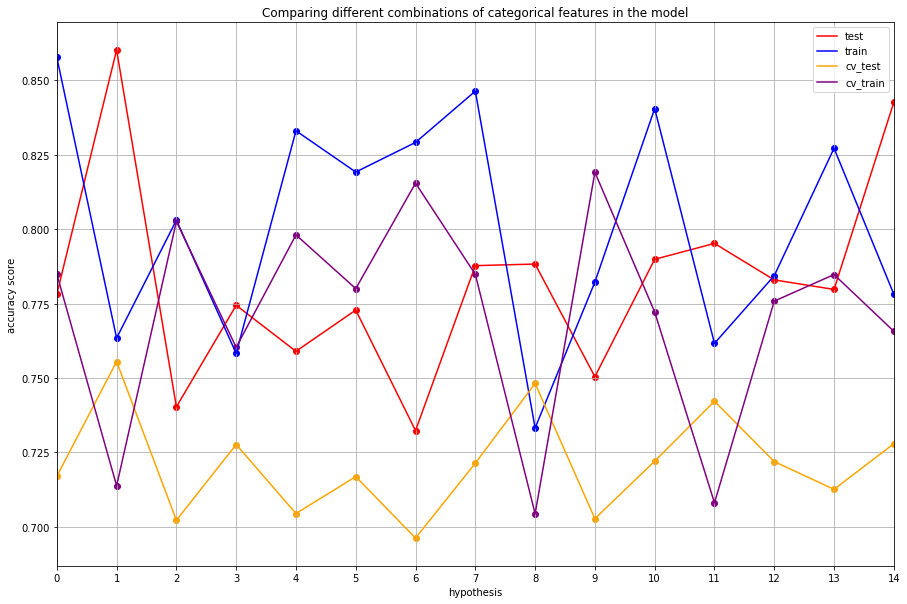

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(scores)), scores[:, 0], color='red', label='test')
ax.plot(range(len(scores)), scores[:, 1], color='blue', label='train')
ax.plot(range(len(scores)), scores[:, 2], color='orange', label='cv_test')
ax.plot(range(len(scores)), scores[:, 3], color='purple', label='cv_train')
ax.scatter(range(len(scores)), scores[:, 0], color='red')
ax.scatter(range(len(scores)), scores[:, 1], color='blue')
ax.scatter(range(len(scores)), scores[:, 2], color='orange')
ax.scatter(range(len(scores)), scores[:, 3], color='purple')

ax.set_xlabel('hypothesis')
ax.set_xlim(0, 14)
ax.set_xticks(range(0, 15))
ax.set_ylabel('accuracy score')
ax.set_title('Comparing different combinations of categorical features in the model')
ax.grid(True)
ax.legend()

In [11]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(silent=True)
params = {'max_depth': (2, 3, 4), 'n_estimators': (60, 80, 100)}
gs = GridSearchCV(xgb, params, n_jobs=4, verbose=True)

In [24]:
def get_ohe_matrix(arr):
    arr = arr.astype('int32')
    ohe_matrix = np.zeros((arr.size, arr.max()+1))
    ohe_matrix[np.arange(arr.size), arr] = 1
    return ohe_matrix

In [39]:
from sklearn.preprocessing import LabelEncoder

def convert_data(data, hyp, return_les=False):
    assert type(hyp) == list
    ohe_matricies = []
    les = [] # label encoder list for each feature in hyp
    for feature_i in hyp:
        le_f = LabelEncoder()
        ohe_matrix = get_ohe_matrix(le.fit_transform(data[:, feature_i]))
        les.append(le_f)
        ohe_matricies.append(ohe_matrix)
        
    ohe_matricies = np.concatenate(ohe_matricies, axis=1)
    converted_data = data[:, [x for x in range(data.shape[1]) if x not in hyp]] 
    converted_data = np.concatenate((converted_data, ohe_matricies), axis=1)
    assert converted_data.shape[0] == data.shape[0]
    
    if return_les:
        return converted_data, les
    
    return converted_data

In [143]:
# UNFINISHED (xgb training)
/


for hyp in tqdm_notebook(itms):
    cat_f = eval(hyp[0])
    cat = XGBClassifier()
    data = X.copy()
    data = convert_data(data, cat_f)
    break
    
    for tr_ind, tst_ind in tqdm_notebook(kfold.split(X, y)):
        # get split sample
        x_tr, y_tr = data[tr_ind], y[tr_ind]
        x_tst, y_tst = data[tst_ind], y[tst_ind]

        
        
        xgb.fit(x_tr, y_tr)
         
        train_score = cat.score(x_tr, y_tr)
        test_score = cat.score(x_tst, y_tst)
        train_scores.append(train_score)
        test_scores.append(test_score)
        
        
    cv_train = np.mean(train_scores)
    cv_test = np.mean(test_scores)
    train_scores = []
    test_scores = []
    cat_feature_dict[hyp[0]].extend([cv_test, cv_train])

NameError: name 'XGBClassifier' is not defined

# Smart Feature Selection

In [6]:
# PLEASE RUN 5 CODE CELLS FROM THE BEGINNING OF THE NOTEBOOK FIRSTLY   
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook, tqdm
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

X = pd.concat((X_train, X_test)).as_matrix()
y = pd.concat((y_train, y_test)).as_matrix()

In [7]:
class BaseSelector(object):
    def __init__(self, estimator, data, cat_features, fit_params={}, kf_splits=2):
        assert type(data) == tuple and len(data) == 2, 'invalid data type'
        assert data[0].ndim == 2 and data[1].ndim == 1, "invalid data shape"
        
        self.estimator = estimator
        self.model = estimator
        self.fit_params = fit_params
        self.X, self.y = data[0], data[1]
        self.cat_features = cat_features
        self.n_features = len(cat_features)
        self.feature_selection_list = []
        self.history_scores = []
        self.kfold = KFold(n_splits=kf_splits, shuffle=True)
        
        
    def get_best_configuration(self):
        return self.feature_selection_list

In [12]:
class AddDel(BaseSelector):
    """ADD-DEL cyclic implementation"""
    def __init__(self, estimator, data, cat_features, *args):
        super(AddDel, self).__init__(estimator, data, cat_features, *args)
        self.best_score = 0
    
    def _add(self):
        # ADD cycle
        while True:
            # average score for each feature (concerning kfold)
            f_scores = np.zeros(self.n_features) 
            for i, feature in tqdm_notebook(enumerate(self.cat_features)):
                if feature not in self.feature_selection_list:
                    # score on already selected features + current feature (i)
                    self.feature_selection_list.append(feature)
                    f_score = self._train_est_cv(self.X, self.y,
                                                 cat_features=self.feature_selection_list) 
                    
                    self.feature_selection_list.remove(feature)
                    f_scores[i] = f_score

            best_feature_ind = np.argmax(f_scores)
            best_feature = self.cat_features[best_feature_ind]
            add_score = f_scores[best_feature_ind]
            
            if self.best_score < add_score:
                self.feature_selection_list.append(best_feature)
                self.best_score = add_score
                self.history_scores.append((self.best_score, list(self.feature_selection_list)))
                print best_feature, 'feature added;', 'cost function value:', self.best_score
            else:
                break
        
    def _del(self):
        # DEL cycle
        while True:
            f_scores = np.zeros(self.n_features)
            for i, feature in tqdm_notebook(enumerate(self.feature_selection_list)):
                ind = self.feature_selection_list.index(feature)
                self.feature_selection_list.pop(ind)
                # train without i-th feature
                f_score = self._train_est_cv(self.X, self.y, 
                                             cat_features=self.feature_selection_list)
                
                self.feature_selection_list.insert(ind, feature)
                f_scores[i] = f_score
                
            worst_feature_ind = np.argmax(f_scores)
            worst_feature = self.cat_features[worst_feature_ind]
            del_score = f_scores[worst_feature_ind]
            
            if self.best_score < del_score:
                self.feature_selection_list.remove(worst_feature)
                self.best_score = del_score
                self.history_scores.append((self.best_score, list(self.feature_selection_list)))
                print worst_feature, 'feature removed;', 'cost function value:', self.best_score
            else:
                break
    
    def _train_est_cv(self, X, y, cat_features):
        test_scores = []
        train_scores = []
        for tr_ind, tst_ind in self.kfold.split(X, y):
            # get split sample
            x_tr, y_tr = X[tr_ind], y[tr_ind]
            x_tst, y_tst = X[tst_ind], y[tst_ind]
            # for catboost 
            self.model.fit(Pool(x_tr, y_tr, cat_features=cat_features), **self.fit_params)
            # for lgb
            #self.model.fit(x_tr, y_tr, categorical_feature=cat_features, **self.fit_params)
            test_scores.append(self.estimator.score(x_tst, y_tst))
            train_scores.append(self.estimator.score(x_tr, y_tr))
        
        self.model = self.estimator # reset model
        return self._cost_function(np.mean(train_scores), np.mean(test_scores))
    
    def _cost_function(self, train_score, test_score):
        return test_score * (1 - np.abs(train_score - test_score))    
    
    def fit(self, n_train_iters):
        for i in range(n_train_iters):
            # add cycle
            print 'ADD iter'
            self._add()
            print 'cost function value:', self.best_score
            print 'selected_cat_features:', self.feature_selection_list 
            
            print 'DEL iter'
            self._del()
            print 'cost function value:', self.best_score
            print 'selected_cat_features:', self.feature_selection_list 

In [13]:
cat = CatBoostClassifier(iterations=400, verbose=False)
lgb = LGBMClassifier(n_estimators=20, max_depth=2)

add_del = AddDel(estimator=cat, data=(X, y), cat_features=[0, 1, 2, 3, 4, 8, 9, 10, 11, 23, 21, 20, 19])

In [14]:
%%time
add_del.fit(n_train_iters=2)

ADD iter



0 feature added; cost function value: 0.601776853333



23 feature added; cost function value: 0.617192408889



9 feature added; cost function value: 0.637334933333



10 feature added; cost function value: 0.64536688



4 feature added; cost function value: 0.676345564444



19 feature added; cost function value: 0.6885784



8 feature added; cost function value: 0.70123104



21 feature added; cost function value: 0.704866168889



20 feature added; cost function value: 0.717242666667



cost function value: 0.717242666667
selected_cat_features: [0, 23, 9, 10, 4, 19, 8, 21, 20]
DEL iter



cost function value: 0.717242666667
selected_cat_features: [0, 23, 9, 10, 4, 19, 8, 21, 20]
ADD iter



cost function value: 0.717242666667
selected_cat_features: [0, 23, 9, 10, 4, 19, 8, 21, 20]
DEL iter



cost function value: 0.717242666667
selected_cat_features: [0, 23, 9, 10, 4, 19, 8, 21, 20]
CPU times: user 59min 29s, sys: 7min 17s, total: 1h 6min 46s
Wall time: 19min 10s


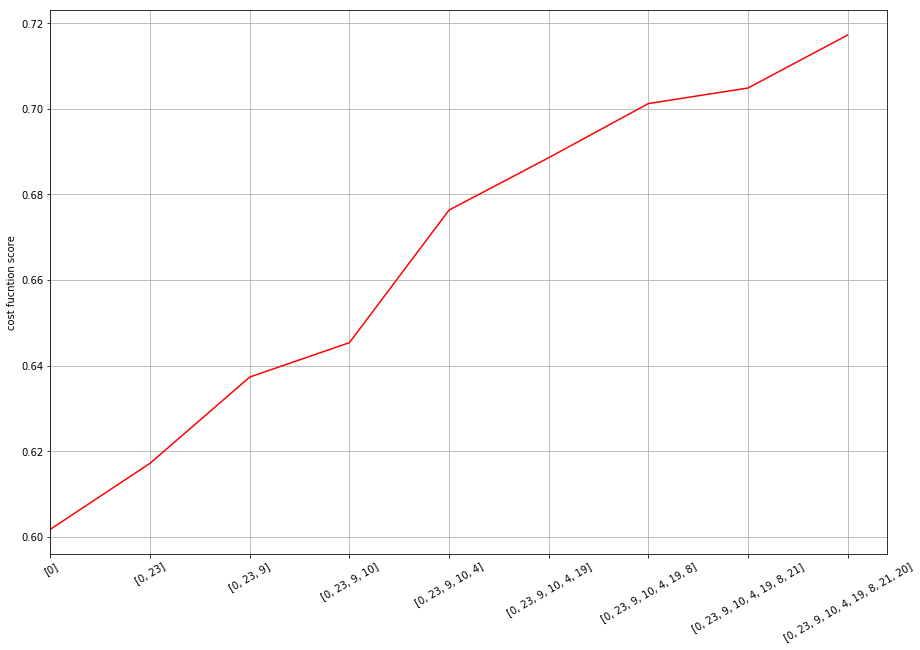

In [26]:
plt.subplots(figsize=(15, 10))
scores = map(lambda x: x[0], add_del.history_scores)
configurations = map(lambda x: str(x[1]), add_del.history_scores)
plt.plot(scores, color='red')
plt.xticks(range(len(configurations)), configurations, rotation=30)
plt.ylabel('cost fucntion score')
plt.xlim(0)
plt.grid(True)
plt.show()

In [21]:
# best confs: [8, 4, 23, 10, 0, 9, 3], [0, 23, 9, 10, 4, 19, 8, 21, 20]

cat = CatBoostClassifier(1200, depth=8, verbose=False)
test_scores = []
train_scores = []
for tr_ind, tst_ind in tqdm_notebook(kfold.split(X, y)):
    # get split sample
    x_tr, y_tr = X[tr_ind], y[tr_ind]
    x_tst, y_tst = X[tst_ind], y[tst_ind]
    
    cat.fit(x_tr, y_tr, cat_features=add_del.get_best_configuration())#[8, 4, 23, 10, 0, 9, 3])
    train_score = cat.score(x_tr, y_tr)
    test_score = cat.score(x_tst, y_tst)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [22]:
# [0, 23, 9, 10, 4, 19, 8, 21, 20]
print 'train score:', np.mean(train_scores), '\ntest score:', np.mean(test_scores) 

train score: 0.708866666667 
test score: 0.780533333333


In [90]:
# [8, 4, 23, 10, 0, 9, 3]
print 'train score:', np.mean(train_scores), '\ntest score:', np.mean(test_scores)

train score: 0.776466666667 
test score: 0.742533333333


In [24]:
cat = CatBoostClassifier(1200, depth=10, verbose=False)
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, shuffle=True, random_state=42)
cat.fit(X_train, y_train, use_best_model=True, eval_set=(X_test, y_test),
        cat_features=add_del.get_best_configuration())#[8, 4, 23, 10, 0, 9, 3])

In [25]:
# [0, 23, 9, 10, 4, 19, 8, 21, 20]
print 'train score:', cat.score(X_train, y_train), '\ntest score:', cat.score(X_test, y_test) 

train score: 0.713333333333 
test score: 0.870666666667


In [73]:
# [8, 4, 23, 10, 0, 9, 3]
print 'train score:', cat.score(X_train, y_train), '\ntest score:', cat.score(X_test, y_test)

(0.82285714285714284, 0.78844444444444439)

In [44]:
lgb = LGBMClassifier(n_estimators=20, max_depth=2)

lgb.fit(X_train, y_train, categorical_feature=[20, 8, 11])

In [46]:
lgb.score(X_test, y_test), lgb.score(X_train, y_train)

(0.64733333333333332, 0.66866666666666663)

In [46]:
import tensorflow as tf

class NeuralSelector(BaseSelector):
    
    def __init__(self, estimator, data, cat_features, *args):
        super(NeuralSelector, self).__init__(estimator, data, cat_features, *args)
        
        self._x = tf.placeholder(dtype=tf.float32, shape=[None] + self.X.shape, name='input_node')
        self._y = tf.placeholder(dtype=tf.int32, shape=[None] + self.y.shape, name='output_node')
        self.model = self._build_graph()
    
    def _build_graph(self):
        pass
        
        
    def _train_step(self):
        pass
        
    def fit(self, n_train_iters):
        for i in range(n_train_iters):
            pass